In [19]:
import os
import io
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import ipywidgets as widgets
import tensorflow as tf
from keras import models, layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Flatten, Dense, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.utils import to_categorical,plot_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
path_dir='C:\\Users\HP\\PycharmProjects\\pythonProject7\\brain_mri'

In [3]:
train_datasets = 'C:\\Users\HP\\PycharmProjects\\pythonProject7\\brain_mri\\Training'

In [4]:
validation_datasets = 'C:\\Users\HP\\PycharmProjects\\pythonProject7\\brain_mri\\Testing'

In [5]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [6]:
def load_images_from_folder(folder, labels, image_size):
    data = []
    labels_list = []

    for label in labels:
        folderPath = os.path.join(folder, label)
        for file_name in tqdm(os.listdir(folderPath)):
            img = cv2.imread(os.path.join(folderPath, file_name))
            img = cv2.resize(img, (image_size, image_size))
            data.append(img)
            labels_list.append(label)

    return np.array(data), np.array(labels_list)
image_size = 150
# Load training data
X_train, y_train = load_images_from_folder(train_datasets, labels, image_size)
# Load testing data
X_test, y_test = load_images_from_folder(validation_datasets, labels, image_size)


100%|██████████| 74/74 [00:00<00:00, 122.55it/s]


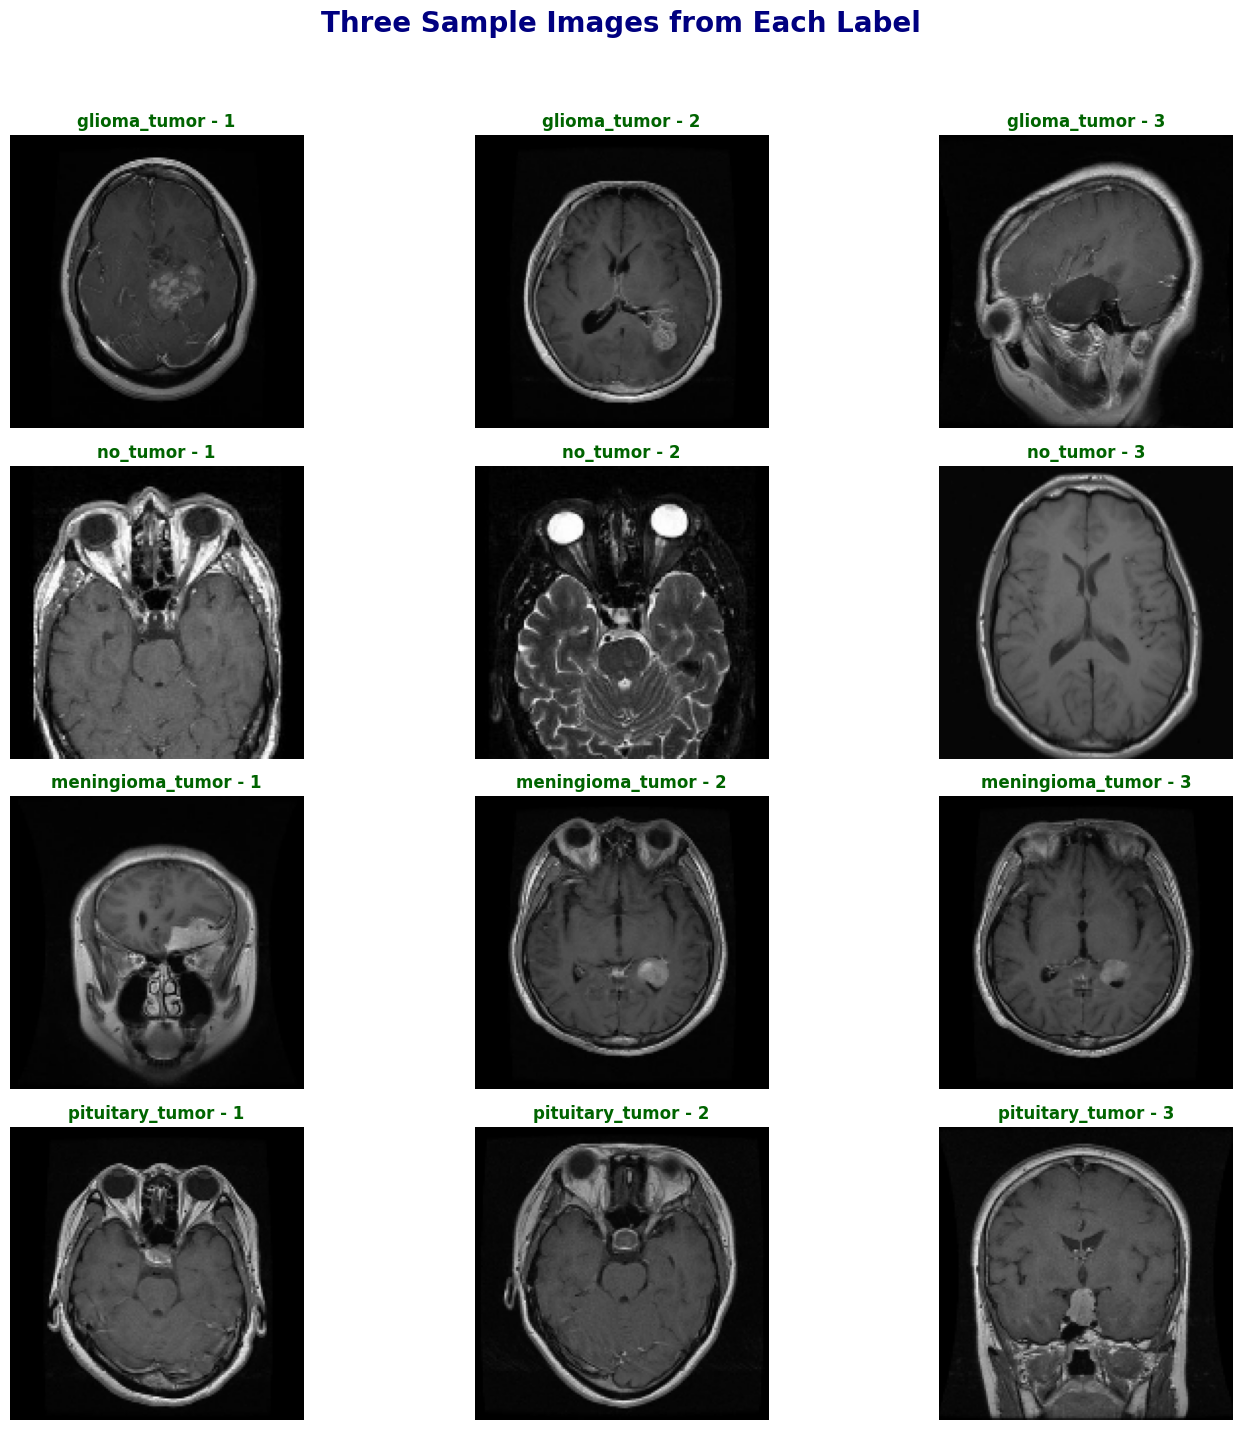

In [7]:
num_rows = len(labels)
num_cols = 3
fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 15))
fig.suptitle('Three Sample Images from Each Label', size=20, fontweight='bold', color='navy')
for i, label in enumerate(labels):
    indices = np.where(y_train == label)[0][:3]

    for j, index in enumerate(indices):
        ax[i, j].imshow(X_train[index])
        ax[i, j].set_title(f'{label} - {j+1}', size=12, fontweight='bold', color='darkgreen')
        ax[i, j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

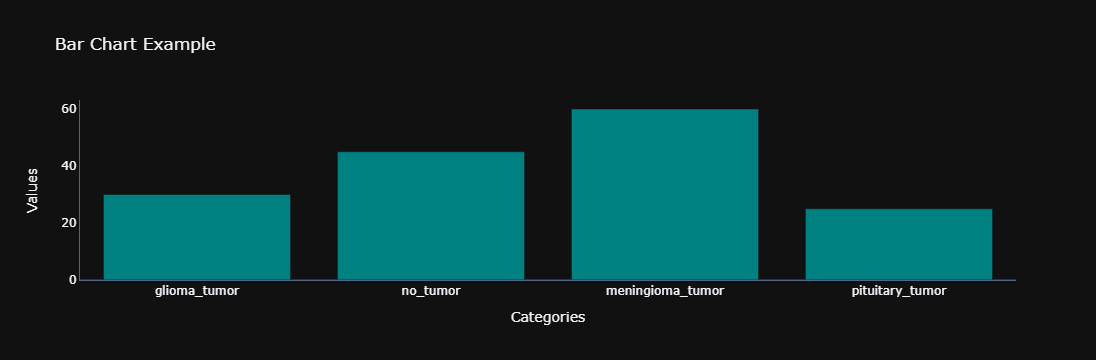

In [21]:

values = [30, 45, 60, 25]

# Create bar chart
fig = go.Figure(data=[go.Bar(x=labels, y=values, marker_color='teal')])

# Design
fig.update_layout(
    title='Bar Chart Example',
    xaxis=dict(title='Categories', showline=True, showgrid=False),
    yaxis=dict(title='Values', showline=True, showgrid=False),
    template='plotly_dark'
)

In [8]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_train.shape


(2870, 150, 150, 3)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=42)

In [10]:
# Cconvert labels to indices and one-hot encode the target variables
def process_labels(y):
    label_indices = [labels.index(label) for label in y]
    return tf.keras.utils.to_categorical(label_indices)

y_train = process_labels(y_train)
y_test = process_labels(y_test)

In [11]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))



16705208/16705208 [==============================] - 116s 7us/step


In [12]:
model = tf.keras.models.Model(
    inputs=effnet.input,
    outputs=tf.keras.layers.Dense(4, activation='softmax')(
        tf.keras.layers.Dropout(rate=0.5)(
            tf.keras.layers.GlobalAveragePooling2D()(effnet.output)
        )
    )
)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [14]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


In [16]:
# TensorBoard Callback
tensorboardCallback = TensorBoard(log_dir='logs')

# ModelCheckpoint Callback
checkpointCallback = ModelCheckpoint(
    "effnet.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="auto",
    verbose=1
)

# ReduceLROnPlateau Callback
reduce_lronplateau = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=2,
    min_delta=0.001,
    mode='auto',
    verbose=1
)

In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboardCallback,checkpointCallback,reduce_lronplateau])

Epoch 1/12


73/73 [==============================] - ETA: 0s - loss: 0.3731 - accuracy: 0.8636
Epoch 1: val_accuracy improved from -inf to 0.79923, saving model to effnet.h5


C:\Users\HP\venv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 167s 2s/step - loss: 0.3731 - accuracy: 0.8636 - val_loss: 0.7624 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 2/12
73/73 [==============================] - ETA: 0s - loss: 0.1544 - accuracy: 0.9466
Epoch 2: val_accuracy improved from 0.79923 to 0.91892, saving model to effnet.h5
73/73 [==============================] - 157s 2s/step - loss: 0.1544 - accuracy: 0.9466 - val_loss: 0.2177 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 3/12
73/73 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9699
Epoch 3: val_accuracy did not improve from 0.91892
73/73 [==============================] - 134s 2s/step - loss: 0.0969 - accuracy: 0.9699 - val_loss: 0.2628 - val_accuracy: 0.9189 - lr: 0.0010
Epoch 4/12
73/73 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9660
Epoch 4: val_accuracy did not improve from 0.91892

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [=====================

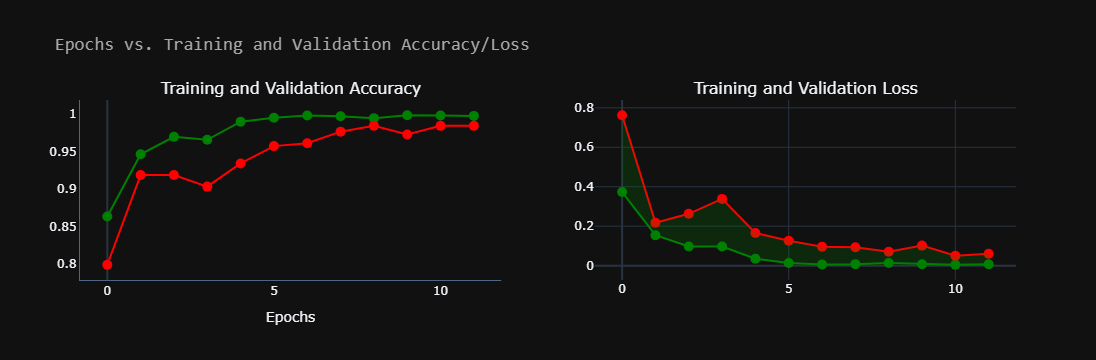

In [28]:


# Data
epochs = [i for i in range(12)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

# Create figure with subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=['Training and Validation Accuracy', 'Training and Validation Loss'],
                    specs=[[{'type': 'scatter'}, {'type': 'scatter'}]])

# Design
layout = go.Layout(
    title='Epochs vs. Training and Validation Accuracy/Loss',
    title_font=dict(size=18, family='monospace', color='darkgrey'),
    showlegend=False,
    xaxis=dict(title='Epochs', showline=True, showgrid=False),
    yaxis=dict(showline=True, showgrid=False),
    template='plotly_dark'
)

# Add traces
fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy',
                         marker=dict(color='green', size=10)), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy',
                         marker=dict(color='red', size=10)), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss',
                         marker=dict(color='green', size=10)), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss',
                         marker=dict(color='red', size=10)), row=1, col=2)

# Shaded areas for loss plot
fig.add_trace(go.Scatter(
    x=epochs + epochs[::-1],
    y=train_loss + val_loss[::-1],
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    hoverinfo="skip",
), row=1, col=2)

# Update layout
fig.update_layout(layout)

# Additional design features
fig.update_traces(marker=dict(line=dict(width=2, color='white')),
                  selector=dict(mode='markers'))

# Add hover information
fig.update_layout(hovermode="x unified")
fig.update_traces(hoverinfo="y+name")

# Show figure
fig.show()


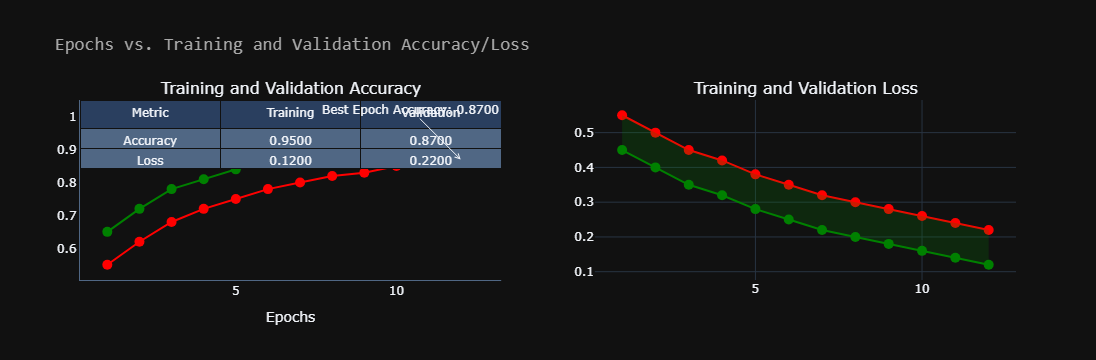

In [27]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
train_acc = [0.65, 0.72, 0.78, 0.81, 0.84, 0.87, 0.89, 0.91, 0.92, 0.93, 0.94, 0.95]
val_acc = [0.55, 0.62, 0.68, 0.72, 0.75, 0.78, 0.80, 0.82, 0.83, 0.85, 0.86, 0.87]
train_loss = [0.45, 0.40, 0.35, 0.32, 0.28, 0.25, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12]
val_loss = [0.55, 0.50, 0.45, 0.42, 0.38, 0.35, 0.32, 0.30, 0.28, 0.26, 0.24, 0.22]


# Create figure with subplot
fig = make_subplots(rows=1, cols=2, subplot_titles=['Training and Validation Accuracy', 'Training and Validation Loss'],
                    specs=[[{'type': 'scatter'}, {'type': 'scatter'}]])

# Design
layout = go.Layout(
    title='Epochs vs. Training and Validation Accuracy/Loss',
    title_font=dict(size=18, family='monospace', color='darkgrey'),
    showlegend=False,
    xaxis=dict(title='Epochs', showline=True, showgrid=False),
    yaxis=dict(showline=True, showgrid=False),
    template='plotly_dark'
)

# Add traces
fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy',
                         marker=dict(color='green', size=10)), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy',
                         marker=dict(color='red', size=10)), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss',
                         marker=dict(color='green', size=10)), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss',
                         marker=dict(color='red', size=10)), row=1, col=2)

# Shaded areas for loss plot
fig.add_trace(go.Scatter(
    x=epochs + epochs[::-1],
    y=train_loss + val_loss[::-1],
    fill='toself',
    fillcolor='rgba(0, 128, 0, 0.2)',
    line=dict(color='rgba(255, 255, 255, 0)'),
    hoverinfo="skip",
), row=1, col=2)

# Vertical lines for key points (e.g., best epoch)
fig.add_trace(go.Scatter(x=[epochs[np.argmax(val_acc)]], y=[val_acc[np.argmax(val_acc)]],
                         mode='markers',
                         marker=dict(color='gold', size=10, symbol='star'),
                         name='Best Epoch',
                         hoverinfo="x+y+name"), row=1, col=1)

# Annotations
fig.add_annotation(x=epochs[np.argmax(val_acc)], y=val_acc[np.argmax(val_acc)],
                   text=f'Best Epoch\nAccuracy: {val_acc[np.argmax(val_acc)]:.4f}',
                   showarrow=True,
                   arrowhead=5,
                   ax=-50,
                   ay=-50)

# Table with summary statistics
table_trace = go.Table(
    header=dict(values=['Metric', 'Training', 'Validation']),
    cells=dict(values=[['Accuracy', 'Loss'], [f'{train_acc[-1]:.4f}', f'{train_loss[-1]:.4f}'],
                       [f'{val_acc[-1]:.4f}', f'{val_loss[-1]:.4f}']]),
    domain=dict(x=[0, 0.45], y=[0, 1]),
    columnwidth=[150, 150],  # Adjust the column width as needed
    name='Summary Table'
)
fig.add_trace(table_trace)

# Update layout
fig.update_layout(layout)

# Additional design features
fig.update_traces(marker=dict(line=dict(width=2, color='white')),
                  selector=dict(mode='markers'))

# Add hover information
fig.update_layout(hovermode="x unified")
fig.update_traces(hoverinfo="y+name")

# Show figure
fig.show()


In [29]:
model.save("brain_tumor_prediction_mri_model.h5")
